# Denoising Diffusion Probabilistic Models

https://arxiv.org/abs/2006.11239 - Paper to replicate

## Define diffusion model

In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn

Using torch 2.0.1


In [2]:
class Diffuser:
    def __init__(self, num_timesteps=200, beta_range=(0.0001, 0.02), device='cuda'):
        self.device = device
        self.T = num_timesteps
        self.betas = torch.linspace(beta_range[0], beta_range[1], num_timesteps, device=self.device)
        self.set_constants()

    def set_constants(self):
        self.alphas = 1. - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0).to(self.device)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar).to(self.device)
        self.sqrt_alpha_reciprocal = (1. / torch.sqrt(self.alphas)).to(self.device)
        self.sqrt_1minus_alpha_bar = torch.sqrt(1 - self.alpha_bar).to(self.device)

    def forwards_diffusion(self, x0, t):
        # 1. Sample from the standard gaussian --> mean = 0, var = I
        noise = torch.randn_like(x0, device=self.device)

        # 2. Multiply to change standard deviation --> mean = 0 var = (1-alpha_bar) * I
        sample = self.sqrt_1minus_alpha_bar[t] * noise

        # 3. Bias it to increase mean --> mean = sqrt(alpha_bar)*x0, var = (1-alpha_bar) * I
        sample += (self.sqrt_alpha_bar[t] * x0) # noise + mean

        return sample.float(), noise.float()
    
    def training_step(self, model, X_0, optimiser, loss_fn, current_epoch):
        t = torch.randint(0, self.T, (X_0.shape[0],1), device=self.device) # Sample a time
        X_t, noise = self.forwards_diffusion(X_0, t) # Get noisy image at time t in the diffusion schedule

        # 1. Forward pass
        pred_noise = model(X_t, t)

        # 2. Calc loss as given in paper, (i.e. between real noisy sample, and parametized noisy sample)
        loss = loss_fn(noise, pred_noise)

        # 3. Optimizer zero-grad
        optimiser.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Update -- gradient ascent
        optimiser.step() 

        return loss
    
    def reverse_diffusion(self, model, num_samples=100):
        # Sample x_T from the standard Gaussian distribution as a scalar tensor
        X_t = torch.randn(size=(num_samples, 2), device=self.device)

        # Reverse the diffusion process -- pass through all the latent spaces until we get back to x0
        for t in reversed(range(self.T)):
            t_index = torch.ones(num_samples, 1, device=self.device, dtype=torch.int) * t
            Z = torch.randn_like(X_t, device=self.device) if t > 1 else torch.zeros_like(X_t, device=self.device)
            X_t = (
                self.sqrt_alpha_reciprocal[t_index] *
                (X_t - (self.betas[t_index] / self.sqrt_1minus_alpha_bar[t_index]) * model(X_t, t_index)) +
                torch.sqrt(self.betas[t_index]) * Z
            )

        return X_t

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_timesteps, embed_dim=4):
        super().__init__()
        
        # 'Attach' a time onto our input data
        self.embedding = nn.Embedding(num_timesteps, embed_dim)

        # Layer stack 
        self.layers = nn.Sequential(
            nn.Linear(input_dim + embed_dim, 128),  
            nn.Sigmoid(),
            nn.Linear(128, 128),  
            nn.Sigmoid(),
            nn.Linear(128, 64),  
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 64),  
            nn.Sigmoid(),
            nn.Linear(64, 128),  
            nn.Sigmoid(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, X, t):
        # Apply embedding to 't'
        t_embedded = self.embedding(t.flatten())
        X_embedded = torch.cat([X, t_embedded], dim=1)  # Concatenate along dimension 1
        
        return self.layers(X_embedded)


## Visualising and generating

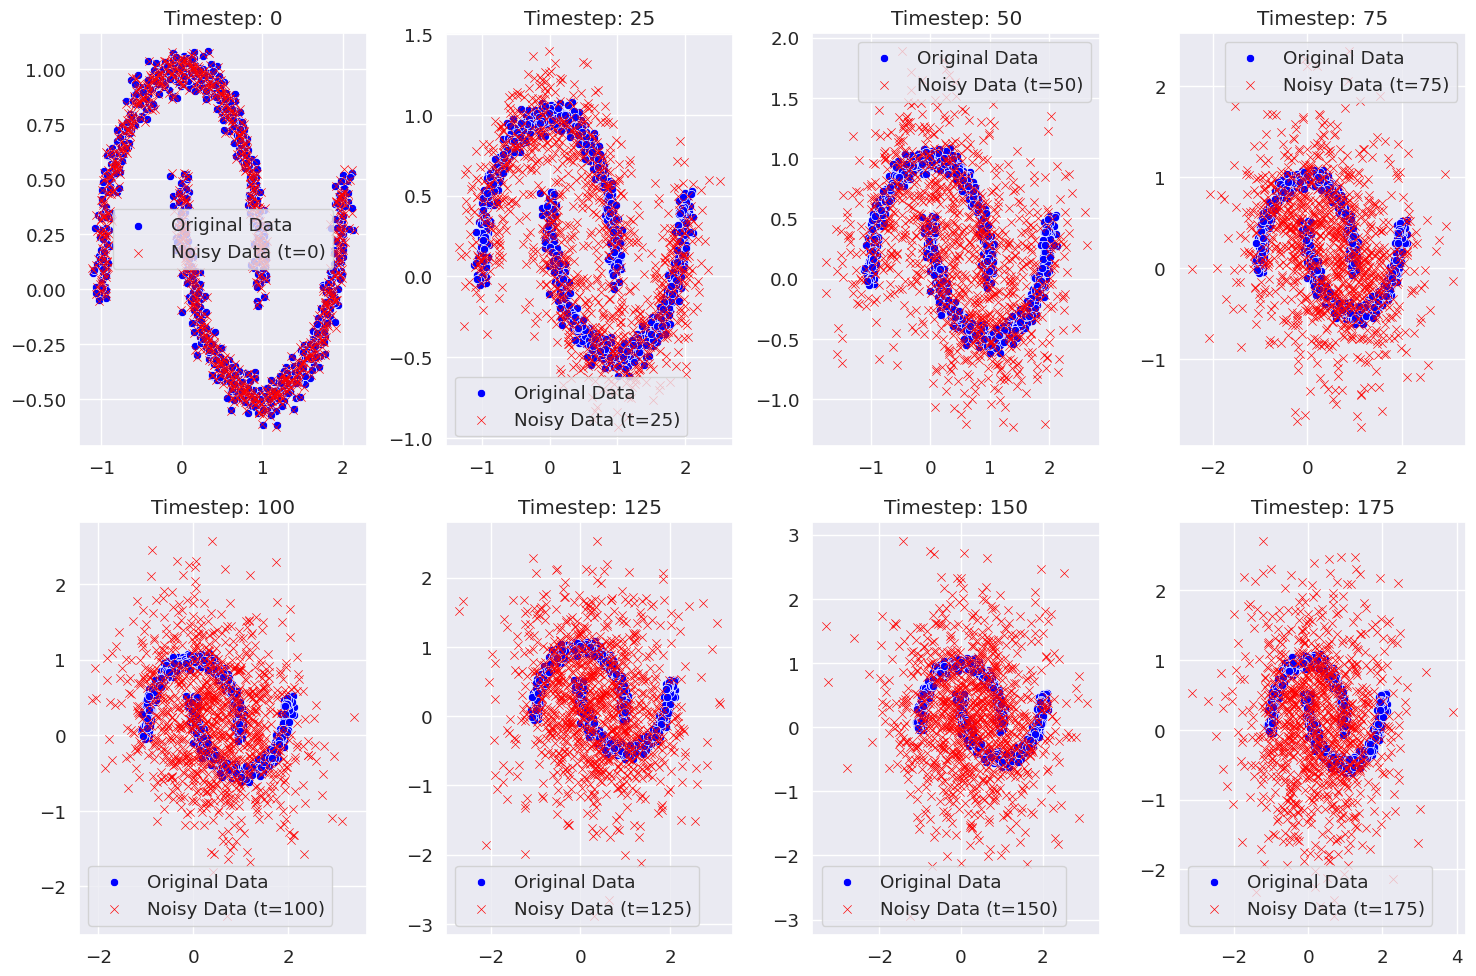

In [4]:
## Visualise a forwards diffusion

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the moons dataset
X, _ = make_moons(n_samples=1000, noise=0.05, random_state=42)
X = torch.tensor(X, device=device)

# Create an instance of the diffusion model -- use defualt settings in this case
D = Diffuser(device=device)

# Calculate the number of rows and columns for subplots
plot_every = 25  # Plot every 10th timestep
num_timesteps = D.T
num_plots = num_timesteps // plot_every
num_cols = min(4, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Sample noisy data points from the DDM at every 10th timestep and create subplots
for t in range(num_timesteps):
    if t % plot_every == 0:  # Plot every 10th timestep
        noisy_data, _ = D.forwards_diffusion(X, t)
        plot_num = t // plot_every
        row = plot_num // num_cols
        col = plot_num % num_cols

        # Convert noisy_data to CPU tensor for plotting
        noisy_data_cpu = noisy_data.cpu()

        # Scatter plots using Seaborn
        sns.scatterplot(x=X[:, 0].cpu().numpy(), y=X[:, 1].cpu().numpy(), color='blue', marker='o', label='Original Data', ax=axs[row, col])
        sns.scatterplot(x=noisy_data_cpu[:, 0].numpy(), y=noisy_data_cpu[:, 1].numpy(),
                        color='red', marker='x', label=f'Noisy Data (t={t})', ax=axs[row, col])
        
        axs[row, col].set_title(f'Timestep: {t}')
        axs[row, col].legend()

plt.tight_layout()
plt.show()


  0%|          | 0/25000 [00:00<?, ?it/s]

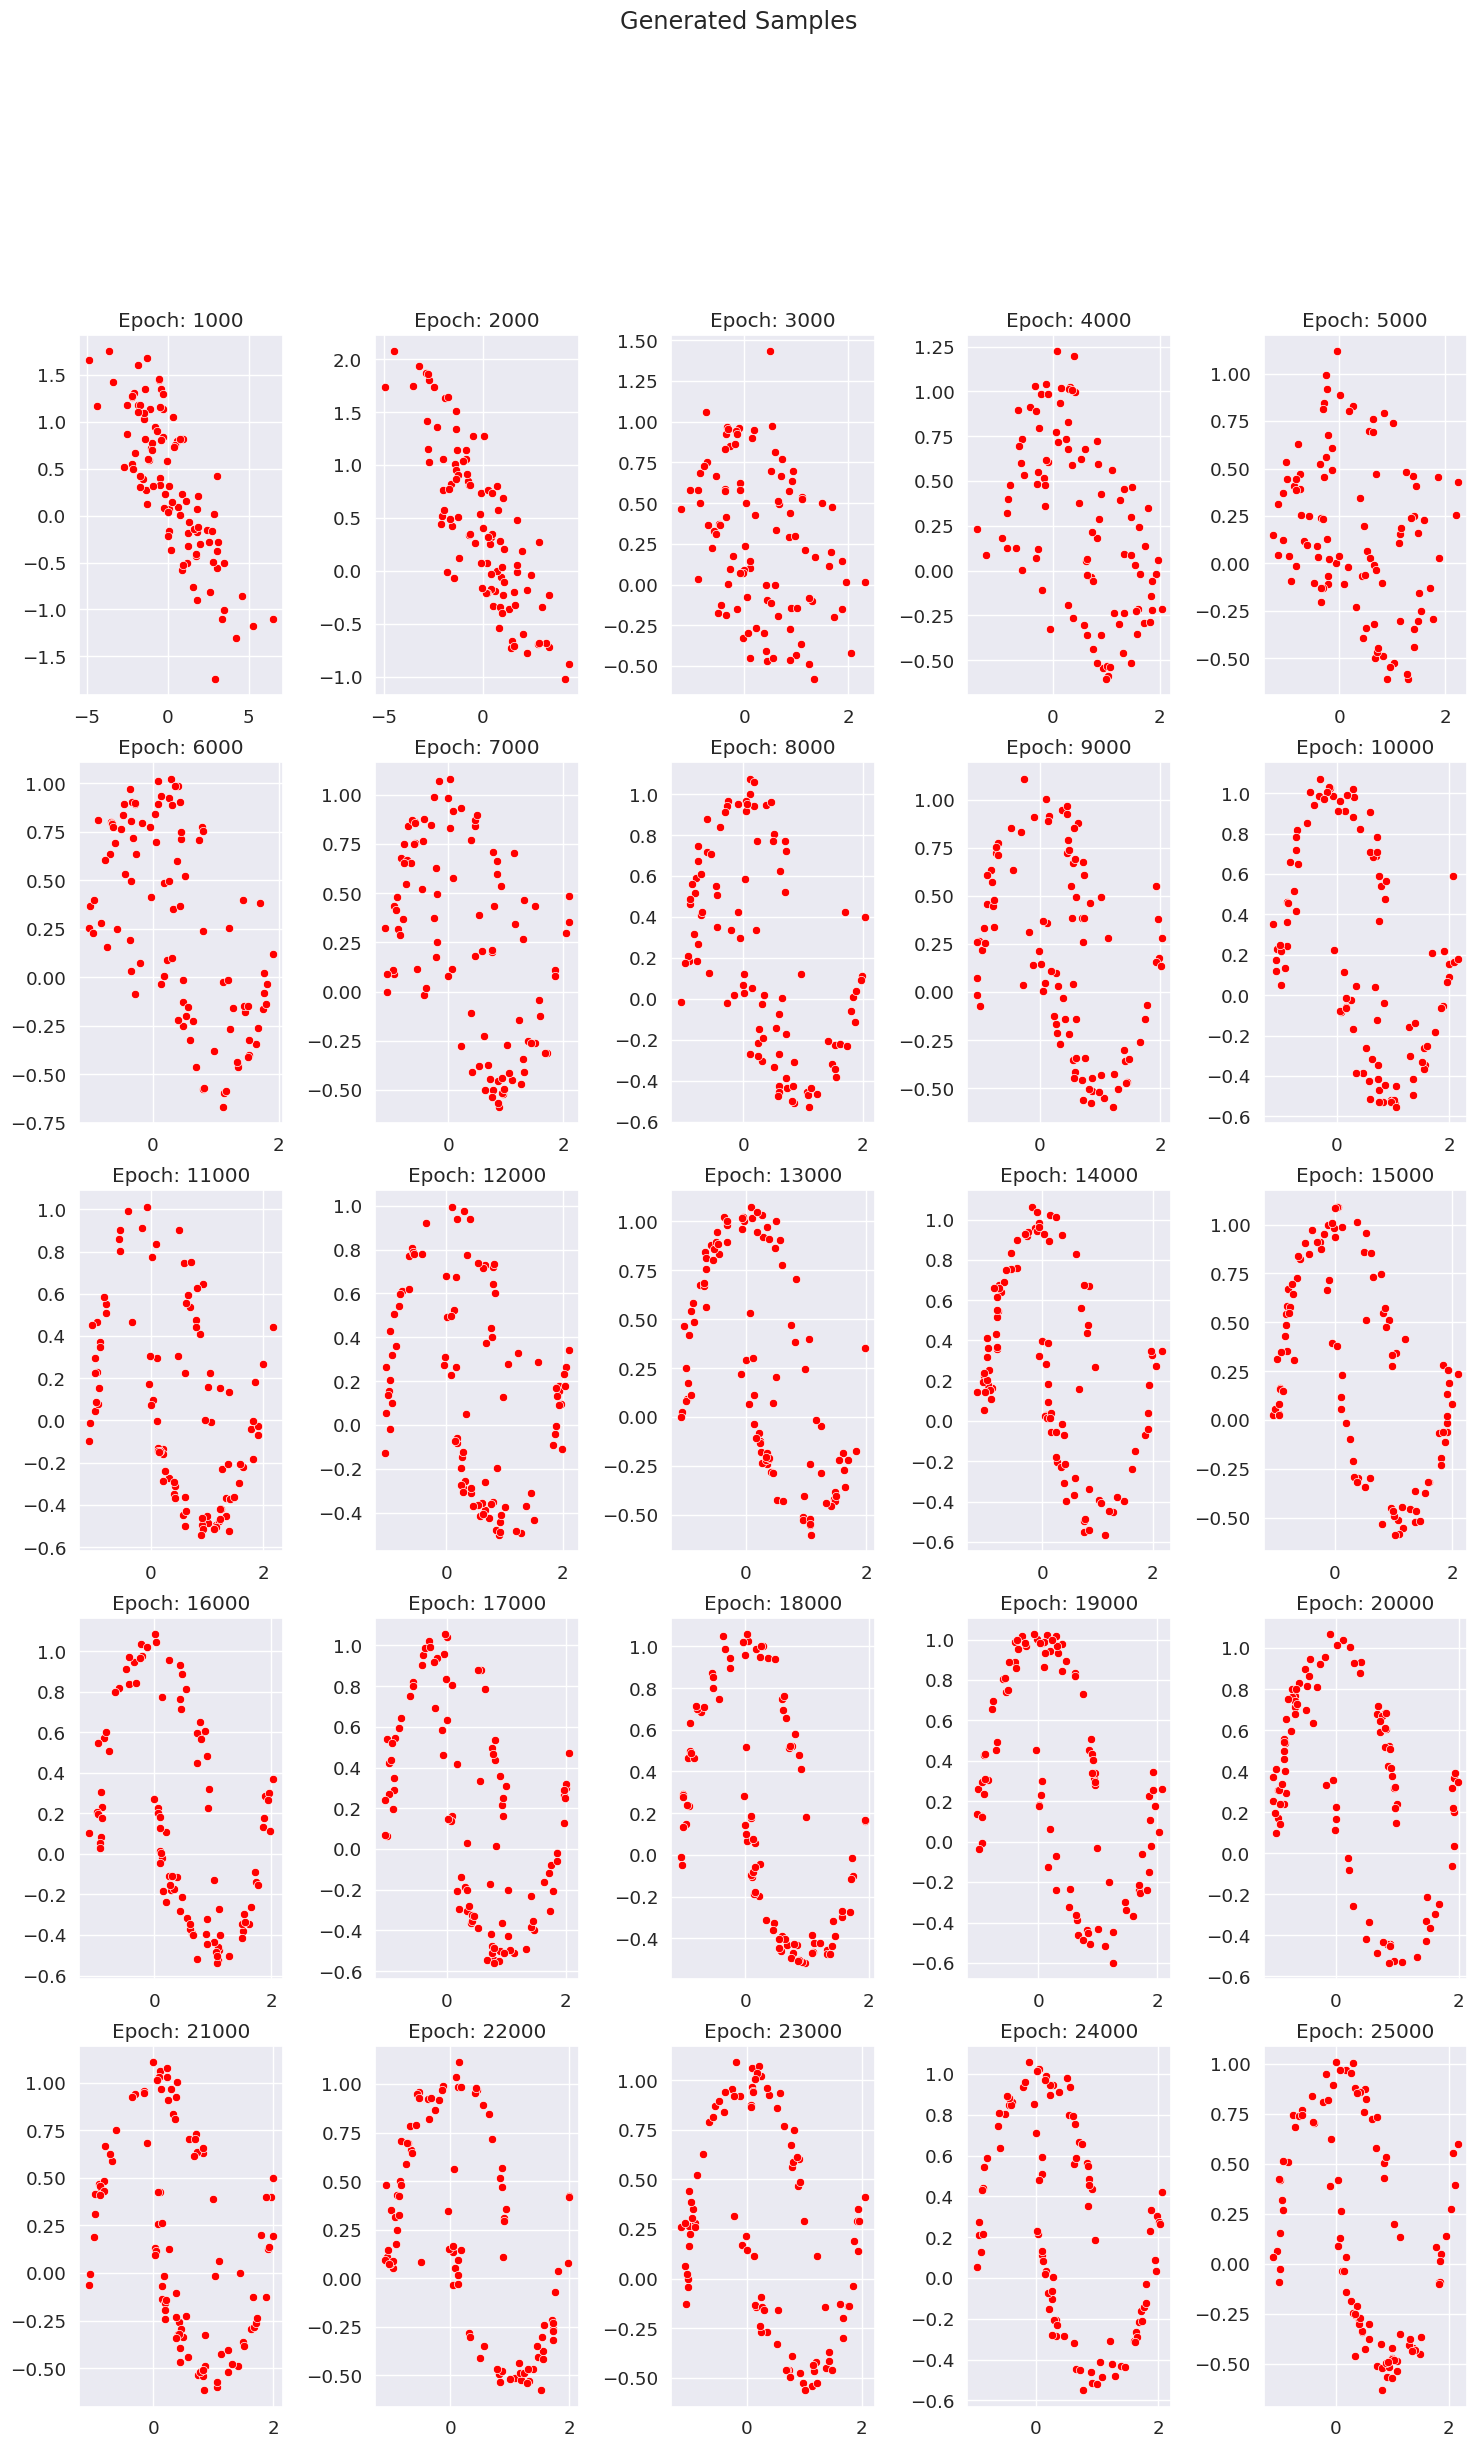

In [5]:
## Training and sampling

NUM_EPOCHS=25000
LR=0.001 
TIMESTEPS=100

# Create an instance of the diffusion model -- use set parameters in this case
D = Diffuser(num_timesteps=TIMESTEPS, device=device)
net = NeuralNet(input_dim=2, output_dim=2, num_timesteps = D.T).to(device)
optimiser = torch.optim.Adam(net.parameters(), lr=LR, amsgrad=True)
loss_function = nn.MSELoss()

# Use loaded dataset
X.to(device)

# Calculate the number of rows and columns for subplots
sample_every = 1000 # Plot every 10th timestep
num_timesteps = D.T
num_plots = (NUM_EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
        avg_loss= D.training_step(model=net, 
                                  X_0=X, 
                                  optimiser=optimiser,
                                  loss_fn=loss_function,
                                  current_epoch=epoch)
        
        if (epoch % sample_every == 0 or epoch == NUM_EPOCHS) and (epoch > 0):
                with torch.no_grad():
                        # Sample from p(x_t) -> reverse diffuse

                        X_0 = D.reverse_diffusion(model=net)
                        
                        plot_num = (epoch // sample_every) - 1
                        row = plot_num // num_cols
                        col = (plot_num % num_cols)

                        # Plot x0 on the specified subplot
                        sns.scatterplot(x=X_0[:, 0].cpu().numpy(), y=X_0[:, 1].cpu().numpy(),
                        color='red', marker='o', ax=axs[row, col])

                        axs[row, col].set_title(f'Epoch: {epoch}')
                
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()